# Feature： Free Shipping Bar with $50 Threshold

## 1. get all packages and data we need

In [1]:
import pandas as pd
import math
import scipy.stats
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator

In [2]:
#download data here: https://drive.google.com/drive/folders/10Q7OSn4BmeW6aoQy1AvvjcEtI3EC9ffW?usp=sharing
df_test_overall = pd.read_csv('./visit-data.csv')
df_cateforymap = pd.read_csv('./category-mapping.csv')
df_rev = pd.read_csv('./rev-data.csv')

## 2. check and filter data

### 2.1 get traffic data ready

In [3]:
#get traffic data we need (test 2 data)
df_test = df_test_overall[df_test_overall['testid'] == 2]

#merge df_test with category mapping table
df_test = df_test.merge(df_cateforymap, how = 'left', on = 'ChannelID')
df_test['Channel Name'] = df_test['Channel Name'].fillna('Undefined')

In [4]:
#check if the numbers of control and varation group are almost equal
df_test.drop_duplicates(['ControlGroup','SessionID']).groupby(['ControlGroup'])['SessionID'].count()

ControlGroup
0    3436671
1    3433997
Name: SessionID, dtype: int64

In [5]:
df_test.drop_duplicates(['ControlGroup','CusID']).groupby(['ControlGroup'])['CusID'].count()

ControlGroup
0    898947
1    898954
Name: CusID, dtype: int64

In [6]:
#check each date's traffic size
df_test.drop_duplicates(['Date', 'SessionID']).groupby(['Date'])['SessionID'].count()

Date
2019-06-14        69
2019-06-15     59090
2019-06-16    127364
2019-06-17    137998
2019-06-18    173863
2019-06-19    194491
2019-06-20    193602
2019-06-21    200563
2019-06-22    199843
2019-06-23    193444
2019-06-24    180545
2019-06-25    222073
2019-06-26    266630
2019-06-27    248291
2019-06-28    257540
2019-06-29    252746
2019-06-30    233204
2019-07-01    199913
2019-07-02    242003
2019-07-03    298940
2019-07-04    305270
2019-07-05    669742
2019-07-06    363540
2019-07-07    290989
2019-07-08    239339
2019-07-09    275926
2019-07-10    358101
2019-07-11    332720
2019-07-12    152829
Name: SessionID, dtype: int64

In [7]:
#exclude the dates with much fewer traffic than others
df_test = df_test[pd.to_datetime(df_test['Date']) > pd.to_datetime('2019-06-15')]
df_test = df_test[pd.to_datetime(df_test['Date']) < pd.to_datetime('2019-07-12')]

In [8]:
df_test.head(5)

,Unnamed: 0,testid,ControlGroup,Date,SessionID,ChannelID,CategoryID,PlatformID,CusID,VisitorTypeID,Time,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Channel Name
0,0,2,1,2019-07-11,7685274065188263037,611,3,1,5299256406894404939,4,434,0,1,0,0,0,Email
1,1,2,1,2019-07-11,6449284229458809869,235,1,1,706543536253348169,4,338,0,1,0,0,0,FB - Paid
2,2,2,0,2019-07-11,509870060026686560,336,1,1,2082623938737374415,2,0,1,0,0,0,0,FB - Paid
3,3,2,1,2019-07-11,3589887684654054988,665,5,1,7908654078631292723,3,25,0,1,0,0,0,Google Ads
4,4,2,1,2019-07-11,7081653159511501375,2023,1,1,8078626604090692368,3,390,0,1,0,0,0,Retargeting


### 2.2 get revenue data ready

In [9]:
#get revenue data ready as array format for removeing outliers
df_rev = df_rev[df_rev['testid'] == 2]
control_rev = df_rev[df_rev['ControlGroup'] == 1]['TotalRevenue'].array
var_rev = df_rev[df_rev['ControlGroup'] == 0]['TotalRevenue'].array

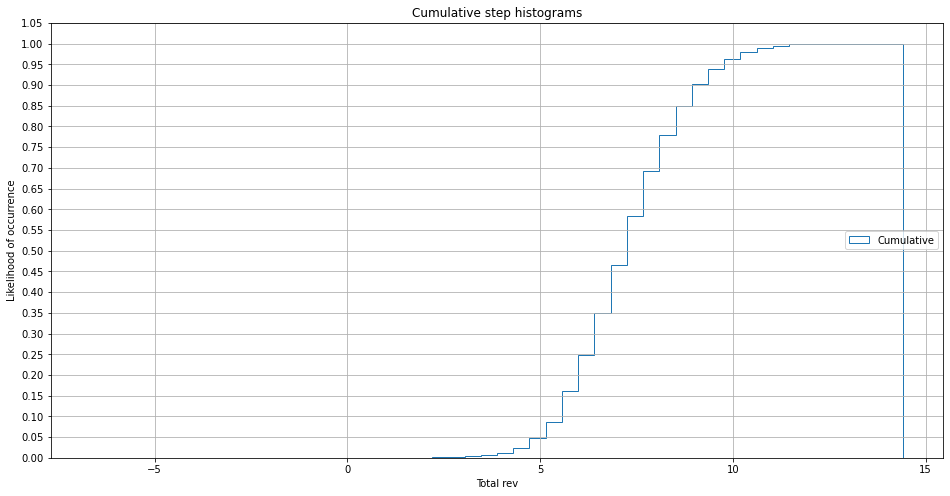

In [10]:
#find out outliers
x = df_rev.loc[df_rev['ControlGroup'] == 0, 'TotalRevenue'].apply(lambda x: math.log(x, 2)) #算出x是2的几次方

n_bins = 50

fig,ax = plt.subplots(figsize = (16,8)) #如果subplots()里面不指明要花多少个行和列，则后面ax后面也不要加索引，加了会报错

n, bins, patches = ax.hist(x, n_bins, density = True, histtype = 'step', cumulative=True, label='Cumulative')

ax.grid(True)
ax.legend(loc = 'right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Total rev')
ax.set_ylabel('Likelihood of occurrence')

#set scale interval as 0.05 for the plot
y_major_locator=MultipleLocator(0.05) 
ax.yaxis.set_major_locator(y_major_locator)

plt.show()

In [11]:
#according to the chart, get the interval
p1 = np.percentile(control_rev, [5, 95])
p2 = np.percentile(var_rev, [5, 95])
p1

array([ 36.7825, 990.    ])

In [12]:
p2

array([ 36.42 , 985.929])

In [13]:
#add TotalRevenue_sq column for df_reft
df_rev['TotalRevenue_sq'] = df_rev['TotalRevenue']**2

#respectively remove outlier for control group(1) and test group(0) by using the interval we got from previous step(p1 & p2)
df_rev_1 = df_rev[(df_rev['TotalRevenue'] > 36.7825) & (df_rev['TotalRevenue'] < 990) & (df_rev['ControlGroup'] == 1)]
df_rev_0 = df_rev[(df_rev['TotalRevenue'] > 36.42) & (df_rev['TotalRevenue'] < 985.929) & (df_rev['ControlGroup'] == 0)]

#merge df_rev_1 & df_rev_0 without outliers as df_rev_new
df_rev_new = pd.concat([df_rev_1, df_rev_0], axis = 0)
df_rev_new = df_rev_new.rename(columns = {'"Date"': 'Date'})

df_rev_new

,testid,ControlGroup,Date,SessionID,TotalRevenue,TotalRevenue_sq
0,2,1,2019-06-26,3170596292771148233,57.98,3361.6804
1,2,1,2019-06-26,4521151331680385048,58.12,3377.9344
2,2,1,2019-06-26,4428930296371807923,383.65,147187.3225
3,2,1,2019-06-26,6052920253472641352,321.28,103220.8384
4,2,1,2019-06-26,2588857339142965515,94.99,9023.1001
...,...,...,...,...,...,...
1436590,2,0,2019-07-09,7643403290484009725,138.99,19318.2201
1436591,2,0,2019-07-09,7402357579629193837,637.95,406980.2025
1436597,2,0,2019-07-09,8602379478020833570,72.99,5327.5401
1436598,2,0,2019-07-09,3157472930894980171,111.99,12541.7601


In [14]:
#merge df_test and df_rev_new
df_test = df_test.merge(df_rev_new, how = 'left', on = ['SessionID', 'Date', 'ControlGroup', 'testid'])
df_test['TotalRevenue'] = df_test['TotalRevenue'].fillna(0)
df_test['TotalRevenue_sq'] = df_test['TotalRevenue_sq'].fillna(0)

#overwrite revenue data as array format again for the following mann whitney method
control_rev = df_test[df_test['ControlGroup'] == 1]['TotalRevenue'].array
var_rev = df_test[df_test['ControlGroup'] == 0]['TotalRevenue'].array

In [15]:
df_test.head(5)

,Unnamed: 0,testid,ControlGroup,Date,SessionID,ChannelID,CategoryID,PlatformID,CusID,VisitorTypeID,Time,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Channel Name,TotalRevenue,TotalRevenue_sq
0,0,2,1,2019-07-11,7685274065188263037,611,3,1,5299256406894404939,4,434,0,1,0,0,0,Email,0.0,0.0
1,1,2,1,2019-07-11,6449284229458809869,235,1,1,706543536253348169,4,338,0,1,0,0,0,FB - Paid,0.0,0.0
2,2,2,0,2019-07-11,509870060026686560,336,1,1,2082623938737374415,2,0,1,0,0,0,0,FB - Paid,0.0,0.0
3,3,2,1,2019-07-11,3589887684654054988,665,5,1,7908654078631292723,3,25,0,1,0,0,0,Google Ads,0.0,0.0
4,4,2,1,2019-07-11,7081653159511501375,2023,1,1,8078626604090692368,3,390,0,1,0,0,0,Retargeting,0.0,0.0


## 3. define z test calculator for continuous distribution

In [16]:
def z_test_calculator_continuous (df, denominator, numerator, numerator_sq):
    
    #get data
    control_denominator = df.loc[1, denominator]
    var_denominator = df.loc[0, denominator]
    
    control_numerator = df.loc[1, numerator]
    var_numerator = df.loc[0, numerator]
    
    #get rate
    control_rate = control_numerator / control_denominator
    var_rate = var_numerator / var_denominator
    
    #variance sq
    control_var = df.loc[1, numerator_sq] / control_denominator - control_rate**2
    var_var = df.loc[0, numerator_sq] / var_denominator - var_rate**2
    
    #z score
    z_score = (control_rate - var_rate) / math.sqrt(control_var / control_denominator + var_var / var_denominator)
    
    #p value
    p_value = scipy.stats.norm.sf(abs(z_score)) 
    
    #lift
    perc_lift = (var_rate - control_rate) / control_rate
    abs_lift = var_rate - control_rate
    
    return (p_value, perc_lift, abs_lift)

## 4. transform data to be prepared for analysis

In [17]:
df = df_test

metrics = ['SawProduct', 'Bounced', 'AddedToCart', 'ReachedCheckout', 'Converted']

df_result_rev = df.drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')[['SessionID']].count()

for metric in metrics:
    a = df[df[metric] == 1].drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')['SessionID'].count()
    a.name = metric
    df_result_rev = df_result_rev.join(a)

df_result_rev.loc[1, 'Rev'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue'])
df_result_rev.loc[1, 'Rev_sq'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue_sq'])

df_result_rev.loc[0, 'Rev'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue'])
df_result_rev.loc[0, 'Rev_sq'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue_sq'])

df_result_rev

,SessionID,SawProduct,Bounced,AddedToCart,ReachedCheckout,Converted,Rev,Rev_sq
ControlGroup,,,,,,,,
0,3330657,2435133,647959,1040348,515454,377076,7.818726e+07,3.086634e+10
1,3328023,2434424,647615,1039177,514895,375873,7.794483e+07,3.082789e+10


## 5. calculation & visualization for overall data

### 5.1 execute calculations & export results as excel for overall data

In [18]:
df = df_test
data_types = ['SessionID', 'CusID']
dic_final_rev = {}

metrics = ['SawProduct', 'Bounced', 'AddedToCart', 'ReachedCheckout', 'Converted']

for data_type in data_types:

    df_result_rev = df.drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[[data_type]].count()

    for metric in metrics:
        a = df[df[metric] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[data_type].count()
        a.name = metric
        df_result_rev = df_result_rev.join(a)

    df_result_rev.loc[1, 'Rev'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue'])
    df_result_rev.loc[1, 'Rev_sq'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue_sq'])

    df_result_rev.loc[0, 'Rev'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue'])
    df_result_rev.loc[0, 'Rev_sq'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue_sq'])

    
    df_final_rev =pd.DataFrame() 

    KPIs = [data_type, 'SawProduct', 'AddedToCart', 'ReachedCheckout', 'Converted']

    j = 0

    for KPI in KPIs:
        result = z_test_calculator_continuous(df_result_rev, KPI, 'Rev', 'Rev_sq')
        df_final_rev.loc[j, 'denominator'] = KPI
        df_final_rev.loc[j, 'numerator'] = 'Rev'
        df_final_rev.loc[j, 'p_value'] = result[0]
        df_final_rev.loc[j, 'perc_lift'] = result[1]
        df_final_rev.loc[j, 'abs_lift'] = result[2]
        j = j + 1

    dic_final_rev[data_type] = df_final_rev

In [19]:
dic_final_rev

{'SessionID':        denominator numerator   p_value  perc_lift  abs_lift
 0        SessionID       Rev  0.226636   0.002317  0.054266
 1       SawProduct       Rev  0.178071   0.002818  0.090233
 2      AddedToCart       Rev  0.244723   0.001981  0.148602
 3  ReachedCheckout       Rev  0.209335   0.002022  0.306156
 4        Converted       Rev  0.483638  -0.000090 -0.018659,
 'CusID':        denominator numerator   p_value  perc_lift  abs_lift
 0            CusID       Rev  0.140245   0.003030  0.267654
 1       SawProduct       Rev  0.149533   0.002892  0.269199
 2      AddedToCart       Rev  0.147909   0.002828  0.311360
 3  ReachedCheckout       Rev  0.205369   0.001887  0.358468
 4        Converted       Rev  0.290361   0.001117  0.263083}

In [40]:
writer_overall = pd.ExcelWriter('test2_continuous_overall.xlsx')

for key in dic_final_rev.keys():
    dic_final_rev[key].to_excel(writer_overall, sheet_name = key)
    
writer_overall.save()

### 5.2 plot significance level reference line for overall data

In [20]:
df = df_test
denominator = 'Converted'
data_type = 'SessionID'

#get daily data
if denominator == data_type:
    denominator_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count()

elif denominator != data_type:    
    denominator_dailydata = df[df[denominator] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count()

if data_type == 'CusID':
    numerator_dailydata = df.drop_duplicates([data_type, 'SessionID', 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue'].sum()
    numerator_sq_dailydata = df.drop_duplicates([data_type, 'SessionID', 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue_sq'].sum()

elif data_type != 'CusID':   
    numerator_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue'].sum()
    numerator_sq_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue_sq'].sum()

In [21]:
denominator_dailydata.head(6)

Date        ControlGroup
2019-06-16  0               11043
            1               10983
2019-06-17  0               11693
            1               11630
2019-06-18  0               14326
            1               14279
Name: SessionID, dtype: int64

In [22]:
#name them
denominator_dailydata.name = denominator
numerator_dailydata.name = 'rev'
numerator_sq_dailydata.name = 'rev_sq'

In [23]:
denominator_dailydata.head(6)

Date        ControlGroup
2019-06-16  0               11043
            1               10983
2019-06-17  0               11693
            1               11630
2019-06-18  0               14326
            1               14279
Name: Converted, dtype: int64

In [24]:
#reset index
denominator_aggdailydata = denominator_dailydata.reset_index()
numerator_aggdailydata = numerator_dailydata.reset_index()
numerator_sq_aggdailydata = numerator_sq_dailydata.reset_index()

In [25]:
denominator_aggdailydata.head(6)

,Date,ControlGroup,Converted
0,2019-06-16,0,11043
1,2019-06-16,1,10983
2,2019-06-17,0,11693
3,2019-06-17,1,11630
4,2019-06-18,0,14326
5,2019-06-18,1,14279


In [26]:
#replace denominator/numearator_aggdailydata's original denominator/ numerator column data with cumsum data
denominator_aggdailydata[denominator] = denominator_aggdailydata.groupby('ControlGroup')[denominator].cumsum()
numerator_aggdailydata['rev'] = numerator_aggdailydata.groupby('ControlGroup')['rev'].cumsum()
numerator_sq_aggdailydata['rev_sq'] = numerator_sq_aggdailydata.groupby('ControlGroup')['rev_sq'].cumsum()

In [27]:
denominator_aggdailydata.head(6)

,Date,ControlGroup,Converted
0,2019-06-16,0,11043
1,2019-06-16,1,10983
2,2019-06-17,0,22736
3,2019-06-17,1,22613
4,2019-06-18,0,37062
5,2019-06-18,1,36892


In [28]:
#calculate p value, perc lift & abs lift for every day by using loop and z test calculator, and then fill them in df_cumsum

df_cumsum = pd.DataFrame()

for date in df.drop_duplicates('Date')['Date'].tolist():
    df_result = denominator_aggdailydata[denominator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True)
    df_result = df_result.merge(numerator_aggdailydata[numerator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])
    df_result = df_result.merge(numerator_sq_aggdailydata[numerator_sq_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])

    sig_result = z_test_calculator_continuous(df_result, denominator, 'rev', 'rev_sq')
    df_cumsum.loc[date, 'sig_level'] = 1 - sig_result[0]
    df_cumsum.loc[date, 'perc_lift'] = sig_result[1]
    df_cumsum.loc[date, 'abs_lift'] =  sig_result[2]

df_result

,Date,Converted,rev,rev_sq
ControlGroup,,,,
0,2019-07-08,336295,6.979640e+07,2.758305e+10
1,2019-07-08,335437,6.961791e+07,2.755214e+10


In [29]:
df_cumsum.sort_index()

,sig_level,perc_lift,abs_lift
2019-06-16,0.654629,0.005091,1.054977
2019-06-17,0.655327,-0.003522,-0.734281
2019-06-18,0.765620,-0.004969,-1.038294
2019-06-19,0.560616,-0.000905,-0.188388
2019-06-20,0.666069,0.002298,0.477348
2019-06-21,0.763498,0.003540,0.735103
2019-06-22,0.664256,0.001953,0.406070
2019-06-23,0.563846,0.000698,0.145018
2019-06-24,0.690638,0.002047,0.424735
2019-06-25,0.703654,0.002058,0.427906


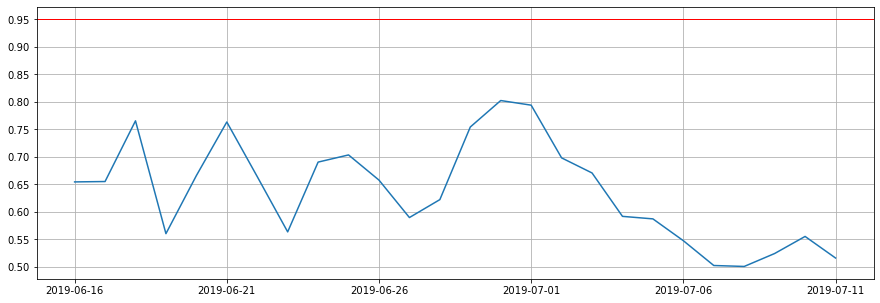

In [30]:
#plot
ax = df_cumsum.sort_index()['sig_level'].plot(figsize = (15, 5))
ax.axhline(y = 0.95, linewidth = 1, color = 'r')
y_major_locator = MultipleLocator(0.05) 
ax.yaxis.set_major_locator(y_major_locator)
ax.grid(True)

## 6. calculation & visualization for data in different cuts

### 6.1 execute calculations & export results as excel for overall data

#### steps are similar with 5.1, so I won't repeat the step by step process

In [31]:
df = df_test
data_types = ['SessionID', 'CusID']
cuts = ['CategoryID', 'Channel Name', 'VisitorTypeID']

dic_final_rev_cut = {}
df_cut = df.copy()

for data_type in data_types:
    
    for cut in cuts:

        for p in set(df_cut[cut]):

            df = df_cut[df_cut[cut] == p]

            metrics = ['SawProduct', 'AddedToCart', 'ReachedCheckout', 'Converted']

            df_result_rev = df.drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[[data_type]].count()

            for metric in metrics:
                a = df[df[metric] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[data_type].count()
                a.name = metric
                df_result_rev = df_result_rev.join(a)

            df_result_rev.loc[1, 'Rev'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue'])
            df_result_rev.loc[1, 'Rev_sq'] = sum(df[df['ControlGroup'] == 1]['TotalRevenue_sq'])

            df_result_rev.loc[0, 'Rev'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue'])
            df_result_rev.loc[0, 'Rev_sq'] = sum(df[df['ControlGroup'] == 0]['TotalRevenue_sq'])

            KPIs = [data_type, 'SawProduct', 'AddedToCart', 'ReachedCheckout', 'Converted']

            df_final_rev = pd.DataFrame() 

            j = 0

            for KPI in KPIs:
                result = z_test_calculator_continuous(df_result_rev, KPI, 'Rev', 'Rev_sq')
                df_final_rev.loc[j, 'denominator'] = KPI
                df_final_rev.loc[j, 'numerator'] = 'Rev'
                df_final_rev.loc[j, 'p_value'] = result[0]
                df_final_rev.loc[j, 'perc_lift'] = result[1]
                df_final_rev.loc[j, 'abs_lift'] = result[2]
                j = j + 1

                dic_final_rev_cut[data_type + '_'+ cut + '_' + str(p)] = df_final_rev

In [32]:
dic_final_rev_cut

{'SessionID_CategoryID_1':        denominator numerator   p_value  perc_lift  abs_lift
 0        SessionID       Rev  0.184919   0.003260  0.085344
 1       SawProduct       Rev  0.167145   0.003440  0.141002
 2      AddedToCart       Rev  0.290329   0.001850  0.151323
 3  ReachedCheckout       Rev  0.204593   0.002427  0.374118
 4        Converted       Rev  0.480651  -0.000125 -0.026326,
 'SessionID_CategoryID_2':        denominator numerator   p_value  perc_lift  abs_lift
 0        SessionID       Rev  0.210827   0.008329  0.181180
 1       SawProduct       Rev  0.200637   0.008671  0.211412
 2      AddedToCart       Rev  0.121346   0.011309  0.795147
 3  ReachedCheckout       Rev  0.216279   0.006446  1.033747
 4        Converted       Rev  0.451270  -0.000881 -0.188964,
 'SessionID_CategoryID_3':        denominator numerator   p_value  perc_lift  abs_lift
 0        SessionID       Rev  0.170546  -0.012530 -0.213522
 1       SawProduct       Rev  0.174149  -0.012318 -0.230590
 2   

In [ ]:
writer_cut = pd.ExcelWriter('test2_continuous_cut.xlsx')

for key in dic_final_rev_cut.keys():
    dic_final_rev_cut[key].to_excel(writer_cut, sheet_name = key)
    
writer_cut.save()

### 6.2 plot significance level reference line for overall data in different cuts

#### steps are similar with 5.1, so I won't repeat the step by step process

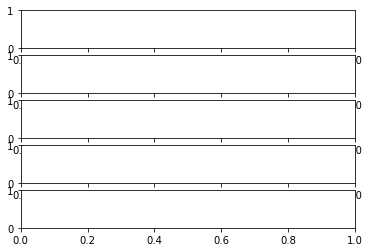

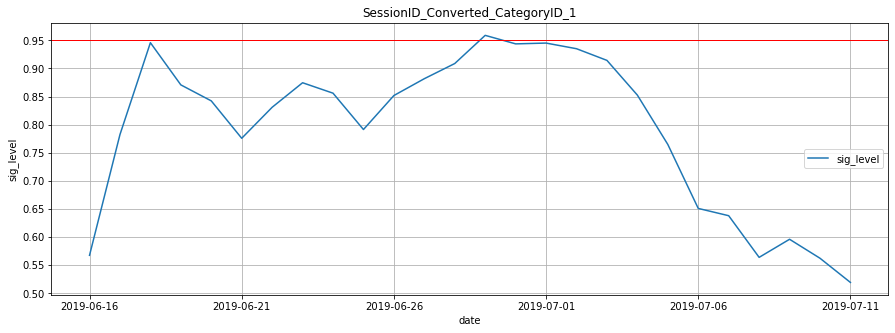

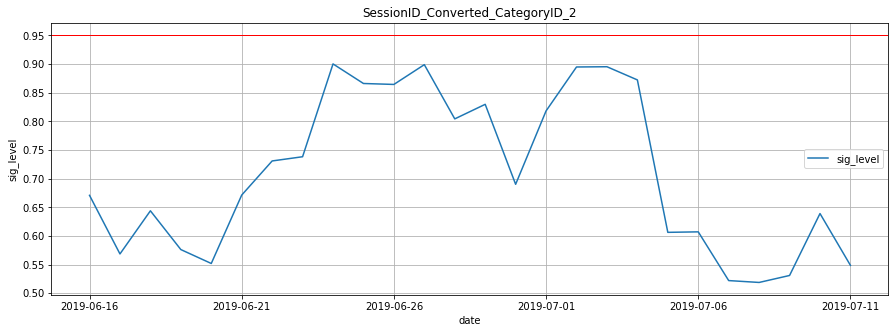

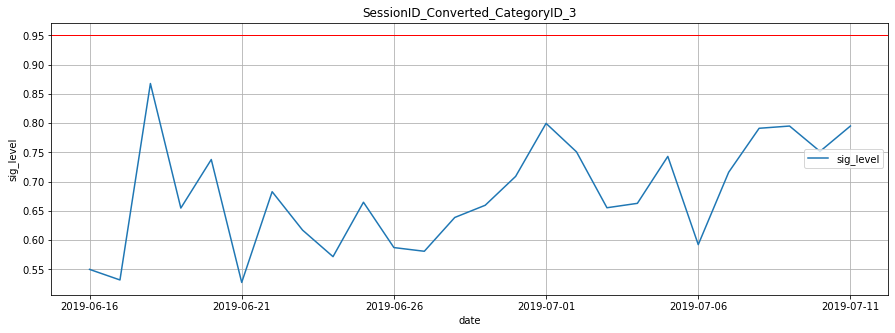

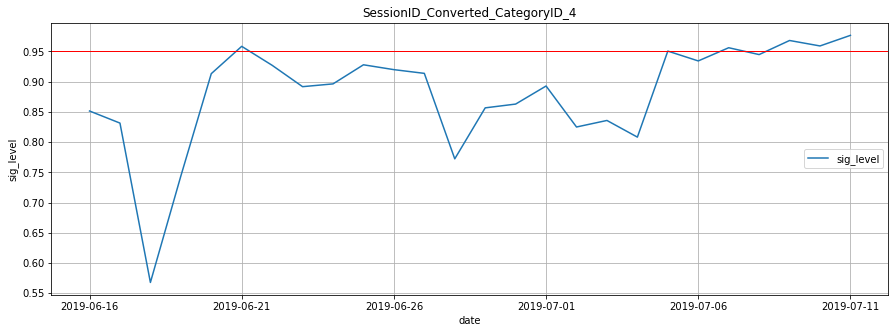

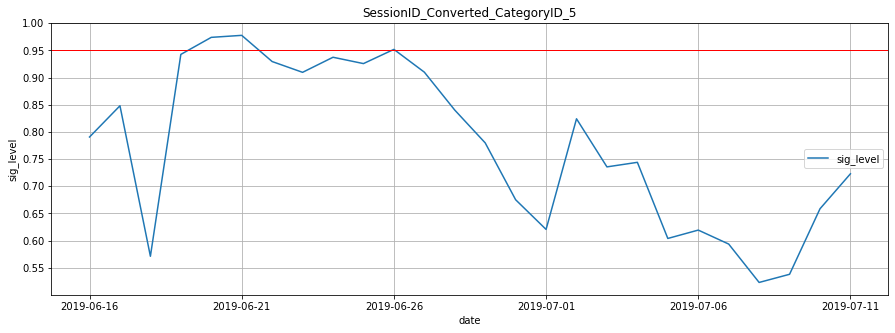

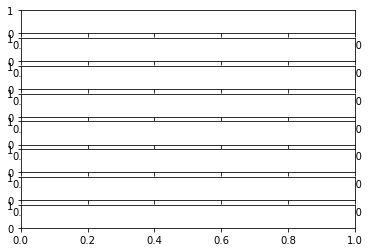

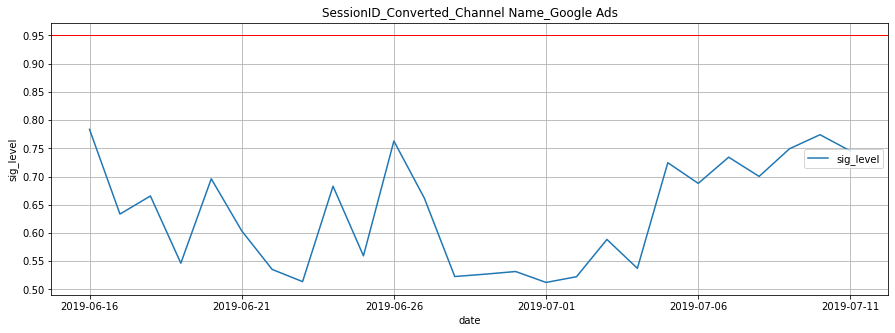

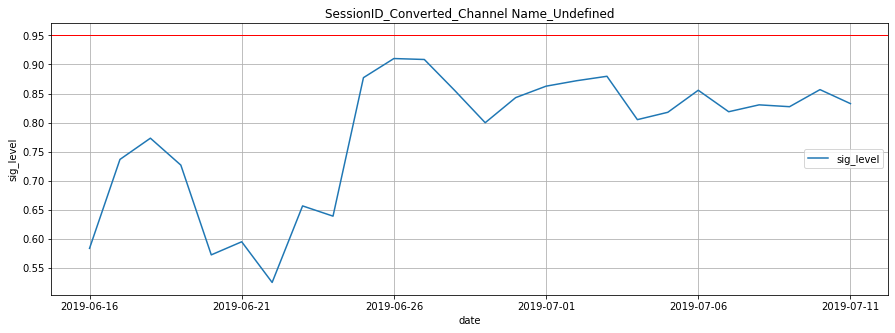

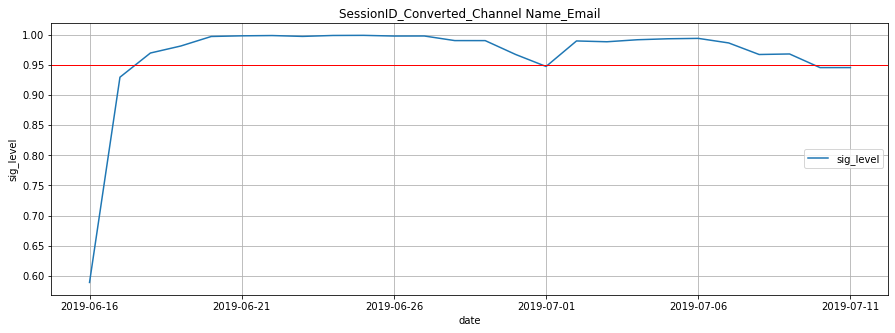

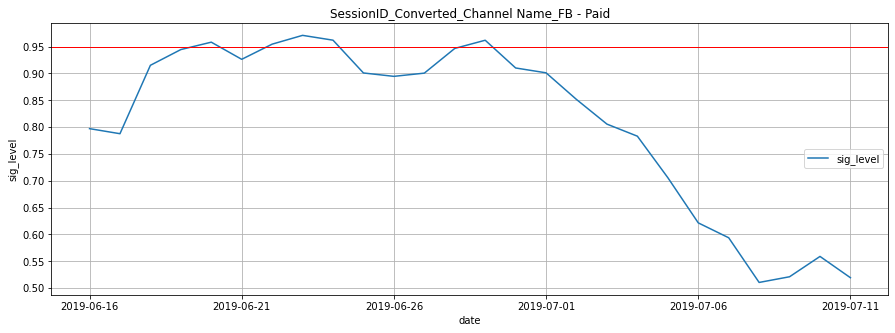

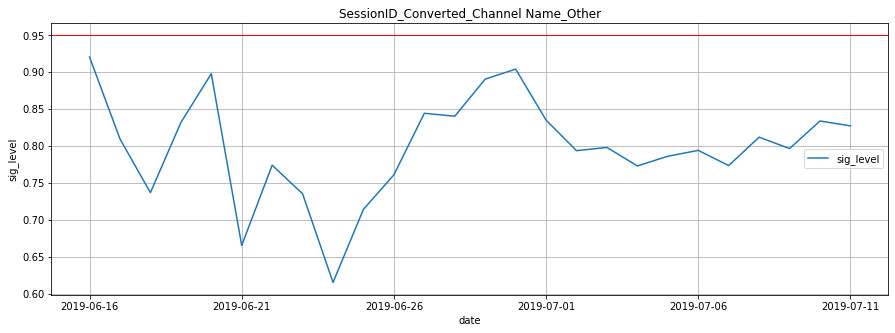

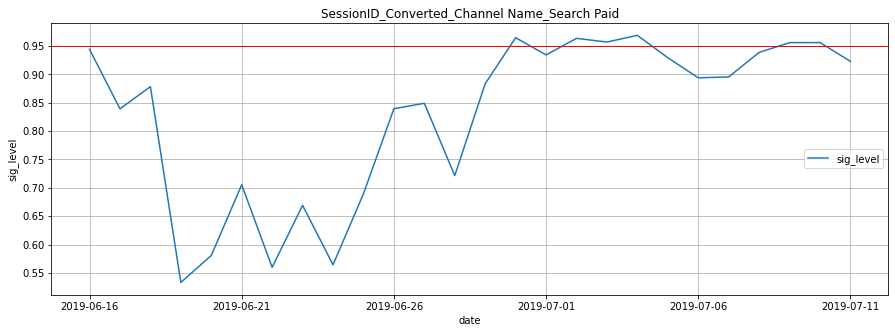

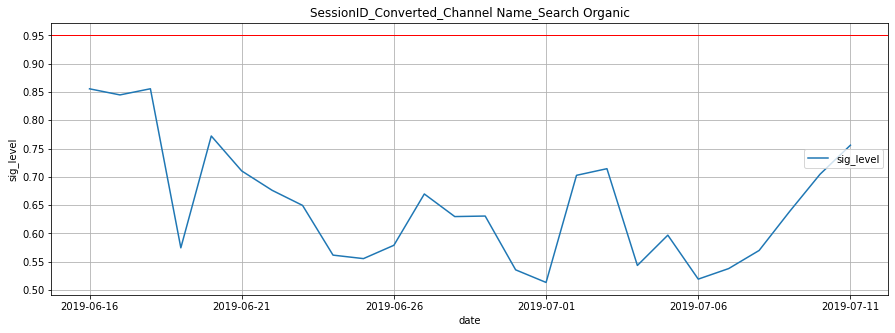

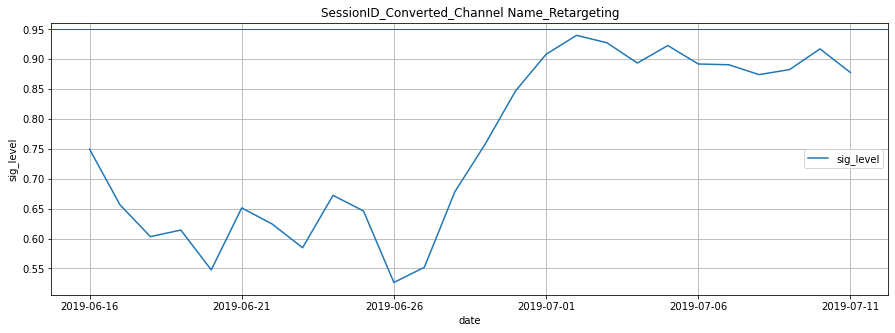

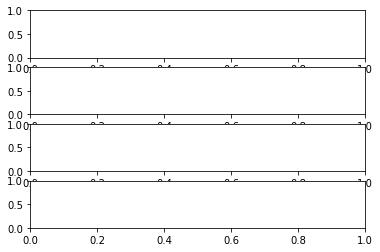

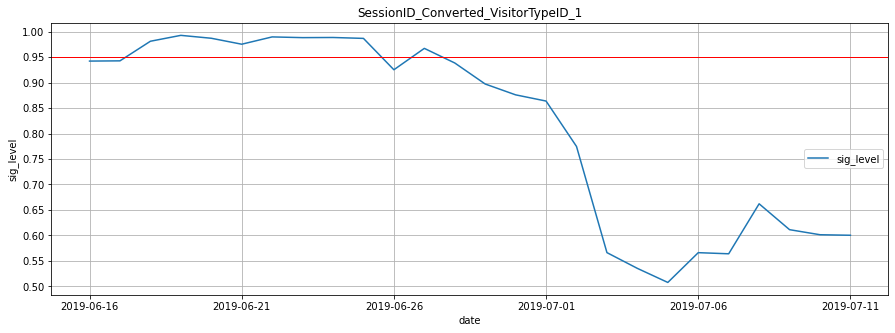

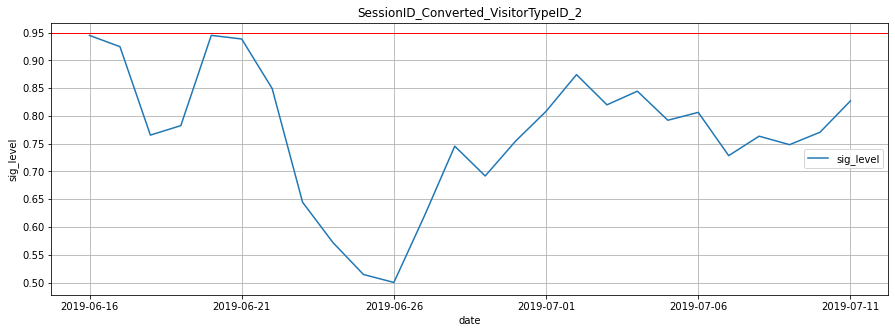

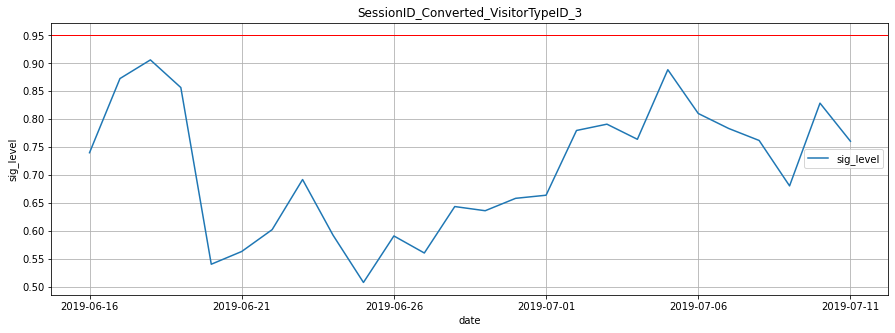

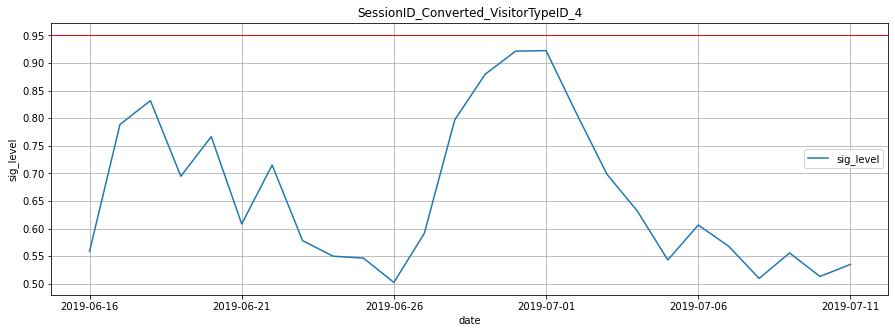

In [33]:
df = df_test
denominator = 'Converted'
data_type = 'SessionID'
cuts = ['CategoryID', 'Channel Name', 'VisitorTypeID']

df_copy = df.copy()
dic_cumsum_cut = {}

for cut in cuts:
    
    j = 0
    
    fig, ax = plt.subplots(len(set(df[cut])))

    for p in set(df_copy[cut]):

        df = df_copy[df_copy[cut] == p]

        if denominator == data_type:
            denominator_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count().unstack(fill_value = 0).stack()

        elif denominator != data_type:    
            denominator_dailydata = df[df[denominator] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count().unstack(fill_value = 0).stack()

        if data_type == 'CusID':
            numerator_dailydata = df.drop_duplicates([data_type, 'SessionID', 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue'].sum()
            numerator_sq_dailydata = df.drop_duplicates([data_type, 'SessionID', 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue_sq'].sum()

        elif data_type != 'CusID':   
            numerator_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue'].sum()
            numerator_sq_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])['TotalRevenue_sq'].sum()

        denominator_dailydata.name = denominator
        numerator_dailydata.name = 'rev'
        numerator_sq_dailydata.name = 'rev_sq'

        denominator_aggdailydata = denominator_dailydata.reset_index()
        numerator_aggdailydata = numerator_dailydata.reset_index()
        numerator_sq_aggdailydata = numerator_sq_dailydata.reset_index()

        denominator_aggdailydata[denominator] = denominator_aggdailydata.groupby('ControlGroup')[denominator].cumsum()
        numerator_aggdailydata['rev'] = numerator_aggdailydata.groupby('ControlGroup')['rev'].cumsum()
        numerator_sq_aggdailydata['rev_sq'] = numerator_sq_aggdailydata.groupby('ControlGroup')['rev_sq'].cumsum()

        df_cumsum = pd.DataFrame()

        for date in df.drop_duplicates('Date')['Date'].tolist():
            df_result = denominator_aggdailydata[denominator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True)
            df_result = df_result.merge(numerator_aggdailydata[numerator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])
            df_result = df_result.merge(numerator_sq_aggdailydata[numerator_sq_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])

            sig_result = z_test_calculator_continuous(df_result, denominator, 'rev', 'rev_sq')
            df_cumsum.loc[date, 'sig_level'] = 1 - sig_result[0]

        dic_cumsum_cut['TestGroup_Cut' + str(p)] = df_cumsum.sort_index()

        ax[j] = dic_cumsum_cut['TestGroup_Cut' + str(p)].plot(figsize = (15, 5))
        ax[j].axhline(y = 0.95, linewidth = 1, color = 'r')

        ax[j].grid(True)
        ax[j].legend(loc = 'right')
        ax[j].set_title(data_type + '_' + denominator + '_' + cut + '_' + str(p))
        ax[j].set_xlabel('date')
        ax[j].set_ylabel('sig_level')
        y_major_locator = MultipleLocator(0.05) #将每个刻度间隔设置为0.05
        ax[j].yaxis.set_major_locator(y_major_locator)

        j = j + 1
